In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.cluster import KMeans
from tensorflow.keras.layers import Input, Reshape, Conv1D, RepeatVector, GRU,LSTM, Conv1DTranspose, Cropping1D, Dense, MaxPooling1D, Flatten, UpSampling1D, Embedding, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn import metrics
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.models import Model, load_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, SGD
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
from collections import Counter
import os
import re
import string
import sys
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from keras.callbacks import EarlyStopping,  ModelCheckpoint


In [2]:
"""Function for preprocessing the text."""
stemmer = SnowballStemmer('english')
def preprocess_text(text, stop_words):
    
    # Check if the text is not a string (e.g., NaN) and return an empty string in such cases
    if not isinstance(text, str):
        return ''
    
     # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', str(text))
    text = re.sub(r'\d+', '', text)

    # Tokenize text and remove stop words
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text
 

In [3]:
# Load Data
MainDf = pd.read_csv('merged csv.csv', encoding='cp1252', on_bad_lines='skip')
MainDf.drop_duplicates(inplace=True)
# Preprocessing
stop_words = set(stopwords.words('english'))
data = np.array(MainDf['description'].apply(lambda x: preprocess_text(x, stop_words)))

# Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(data)

max_len = 48
padded_sequence = pad_sequences(sequences, padding='post', maxlen=max_len)
norm_data = normalize(padded_sequence, axis=1)
new_data = np.reshape(norm_data, (len(norm_data), norm_data.shape[1], 1))

train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)
test_size = len(data) - train_size - val_size

X_train = new_data[:train_size]
X_val = new_data[train_size:train_size+val_size]
X_test = new_data[train_size+val_size:]
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(6704, 48, 1)
(838, 48, 1)
(839, 48, 1)


In [4]:
# Load Labeled Data and Preprocess
df = pd.read_csv('Test_data.csv')
Labels = df['type']
Label_data = df['description'].apply(lambda x: preprocess_text(x, stop_words))
lb_sequences = tokenizer.texts_to_sequences(Label_data)
lb_padded = pad_sequences(lb_sequences, padding='post', maxlen=max_len)
Nor_lb_padded = normalize(lb_padded, axis=1)
lb_new_data = np.reshape(Nor_lb_padded, (len(Nor_lb_padded), Nor_lb_padded.shape[1], 1))
label_encoder = LabelEncoder()
labels_Int = label_encoder.fit_transform(Labels)


In [5]:
# Encoder
input_layer = Input(shape=(max_len,1))
# define the encoder model

encoded = LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = LSTM(16, activation='relu', return_sequences=True)(encoded)
encoded = LSTM(8, activation='relu', return_sequences=True)(encoded)
encoded = LSTM(8, activation='relu', return_sequences=False)(encoded)

# define the decoder model
decoded = RepeatVector(max_len)(encoded)
decoded = LSTM(8, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(8, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(16, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(max_len, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)
optimizer = Adam(learning_rate=0.0005)
autoencoder.compile(optimizer=optimizer,loss='mse')


autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 48, 16)            5184      
                                                                 
 lstm_2 (LSTM)               (None, 48, 8)             800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 repeat_vector (RepeatVecto  (None, 48, 8)             0         
 r)                                                              
                                                             

In [6]:
# Training the model
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True)
checkpoint_filepath = 'CAE_AutoEncoder1.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_val, X_val),shuffle=True, callbacks=[model_checkpoint_callback, early_stopping])
# callbacks=[model_checkpoint_callback, early_stopping]

Epoch 1/50
53/53 [==============================] - 27s 311ms/step - loss: 0.0163 - val_loss: 0.0147
Epoch 2/50
53/53 [==============================] - 14s 271ms/step - loss: 0.0108 - val_loss: 0.0136
Epoch 3/50
53/53 [==============================] - 15s 288ms/step - loss: 0.0106 - val_loss: 0.0141
Epoch 4/50
53/53 [==============================] - 16s 294ms/step - loss: 0.0100 - val_loss: 0.0128
Epoch 5/50
53/53 [==============================] - 16s 301ms/step - loss: 0.0083 - val_loss: 0.0107
Epoch 6/50
53/53 [==============================] - 16s 305ms/step - loss: 0.0075 - val_loss: 0.0097
Epoch 7/50
53/53 [==============================] - 16s 295ms/step - loss: 0.0067 - val_loss: 0.0094
Epoch 8/50
53/53 [==============================] - 16s 299ms/step - loss: 0.0060 - val_loss: 0.0094
Epoch 9/50
53/53 [==============================] - 20s 374ms/step - loss: 0.0056 - val_loss: 0.0093
Epoch 10/50
53/53 [==============================] - 19s 362ms/step - loss: 0.0055 - val_lo

In [7]:
# Get the reconstructed output from the autoencoder
pre_train = autoencoder.predict(X_train)
reconstructed_train = np.reshape(pre_train, newshape=(pre_train.shape[0], -1))
pre_val = autoencoder.predict(X_val)
reconstructed_val = np.reshape(pre_val, newshape=(pre_val.shape[0], -1))
pre_Test = autoencoder.predict(X_test)
reconstructed_Test = np.reshape(pre_Test, newshape=(pre_Test.shape[0], -1))
re_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
re_val = np.reshape(X_val, newshape=(X_val.shape[0], -1))
re_Test = np.reshape(X_test, newshape=(X_test.shape[0], -1))
mse_train = mean_squared_error(re_train, reconstructed_train)
mse_val = mean_squared_error(re_val, reconstructed_val)
mse_Test = mean_squared_error(re_Test, reconstructed_Test)
print(mse_train, mse_val, mse_Test)



27/27 [==============================] - 1s 53ms/step
0.004823511015898269 0.009017369454067047 0.010697338569245665


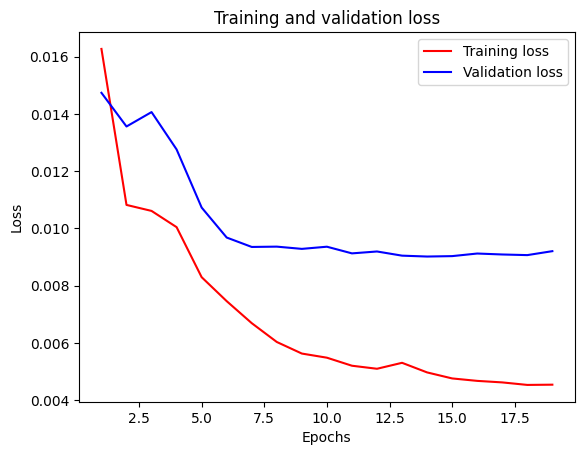

In [8]:
# Plotting training and validation loss
import matplotlib.pyplot as plt
loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Save the trained CAE model
encoder.save("Final_cae_model_Result18.keras")


In [9]:
encoder = load_model("Final_cae_model_Result18.keras")
encoded_train = encoder.predict(X_train)
exp_encoded_train = np.reshape(encoded_train, newshape=(encoded_train.shape[0], -1))
encoded_val = encoder.predict(X_val)
exp_encoded_val = np.reshape(encoded_val, newshape=(encoded_val.shape[0], -1))
lb_encoded_val = encoder.predict(lb_new_data)
exp_lb_encoded_val = np.reshape(lb_encoded_val, newshape=(lb_encoded_val.shape[0], -1))


2/2 [==============================] - 0s 27ms/step


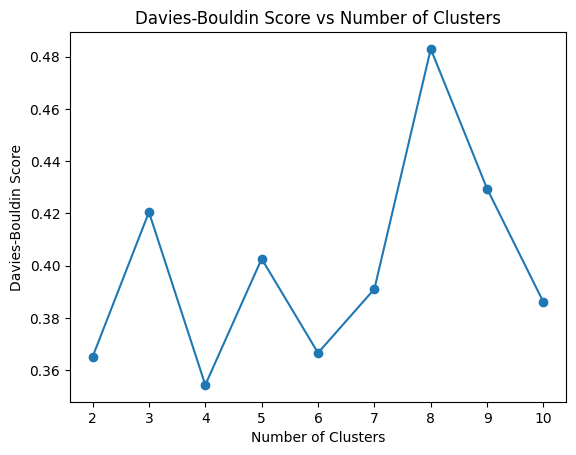

The best cluster number based on Davies-Bouldin score is: 4


In [10]:


# Set the number of cores you want to use
desired_core_count = 4  # Change this to the desired number of cores

os.environ["LOKY_MAX_CPU_COUNT"] = str(desired_core_count)


# Set the range of cluster numbers to evaluate
min_clusters = 2
max_clusters = 10
cluster_range = range(min_clusters, max_clusters + 1)

# Initialize lists to store the scores and fitted models
scores = []
models = []

# Iterate over the cluster range
for n_clusters in cluster_range:
    # Fit KMeans clustering model
    kmeans = KMeans(n_clusters=n_clusters, init='random', n_init=10, random_state=0)
    kmeans.fit(exp_encoded_train)
    models.append(kmeans)

    # Calculate the Davies-Bouldin score
    score = davies_bouldin_score(exp_encoded_train, kmeans.labels_)
    scores.append(score)

# Find the best cluster number with the lowest Davies-Bouldin score
best_cluster = np.argmin(scores) + min_clusters

# Plot the Davies-Bouldin scores
plt.plot(cluster_range, scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score vs Number of Clusters')
plt.show()

# Print the best cluster
print(f"The best cluster number based on Davies-Bouldin score is: {best_cluster}")


In [14]:
kmeans = KMeans(n_clusters=4, init='random', n_init=10, random_state=0)
train_cluster_labels= kmeans.fit_predict(exp_encoded_train)

val_cluster_labels = kmeans.predict(exp_encoded_val)
lb_val_cluster_labels =  kmeans.predict(exp_lb_encoded_val)
joblib.dump(kmeans, 'kmeans_model_final9.kreas')

['kmeans_model_final9.kreas']

In [15]:
# Print the clustering evaluation metrics
#print('Training set silhouette score:', silhouette_score(encoded_train, train_cluster_labels))
#print('Training set Davies-Bouldin score:', davies_bouldin_score(encoded_train, train_cluster_labels))
print('Validation set Davies-Bouldin score:', davies_bouldin_score(exp_encoded_val, val_cluster_labels))
#print('Test set Davies-Bouldin score:', davies_bouldin_score(encoded_test, test_cluster_labels))

Validation set Davies-Bouldin score: 0.5302431781188915


Fault davies matrics 0.3651212109653935
4 Fault davies matrics 0.3543982806787018
9 Fault davies matrics 0.4294457624340831


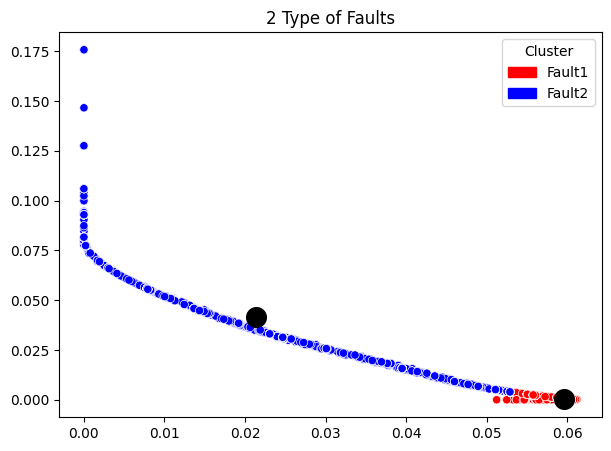

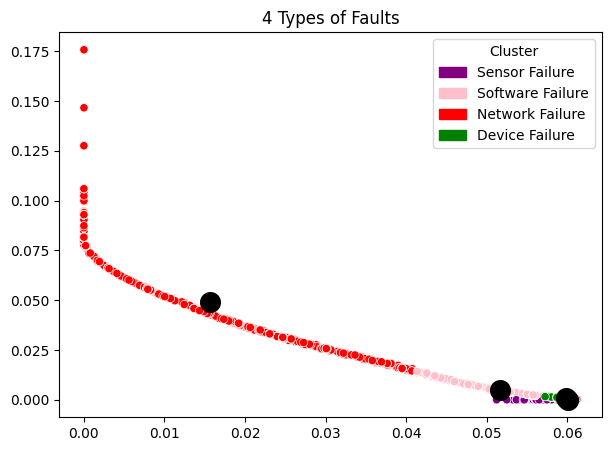

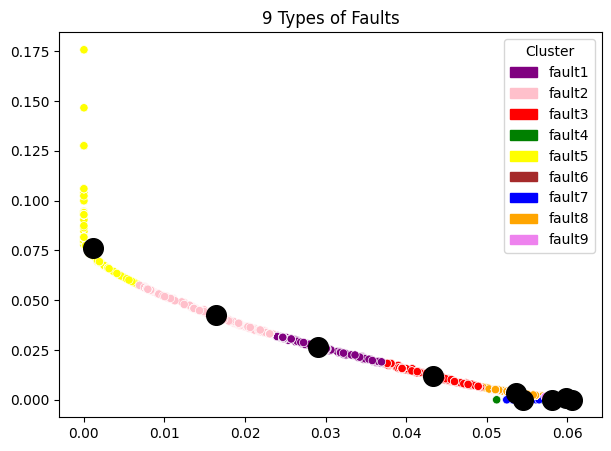

In [13]:
# Create a KMeans model for clustering
kmeans1 = KMeans(n_clusters=2, init='random', n_init=10, random_state=0)

# Fit the model to the data
kmeans1.fit(exp_encoded_train)

# Predict the cluster labels for each data point
train_cluster_labels = kmeans1.predict(exp_encoded_train)


# Further clustering for 4 types of faults
k2 = 4
kmeans2 = KMeans(n_clusters=k2,init='random', n_init=10, random_state=0)
kmeans2.fit(exp_encoded_train)
fault_labels = kmeans2.predict(exp_encoded_train)
# Save the trained model to a file

# Further clustering for 8 types of faults
k3 = 9
kmeans3 = KMeans(n_clusters=k3, init='random', n_init=10,random_state=0)
kmeans3.fit(exp_encoded_train)
More_fault_labels = kmeans3.predict(exp_encoded_train)

# Calculating Davies Bouldin Score
fault_davies = davies_bouldin_score(exp_encoded_train, train_cluster_labels)
four_fault_davies = davies_bouldin_score(exp_encoded_train, fault_labels)
More_fault_davies = davies_bouldin_score(exp_encoded_train, More_fault_labels)

# Output
print(f'Fault davies matrics',fault_davies)
print(f'4 Fault davies matrics',four_fault_davies)
print(f'9 Fault davies matrics',More_fault_davies)

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Create custom legend elements
legend_elements = [
    mpatches.Patch(color='Red', label='Fault1'),
    mpatches.Patch(color='blue', label='Fault2')
]

plt.figure(figsize=(7, 5))
sns.scatterplot(x=exp_encoded_train[:,0], y=exp_encoded_train[:,1], hue=train_cluster_labels, palette=['blue', 'Red'] )
plt.scatter(kmeans1.cluster_centers_[:, 0], kmeans1.cluster_centers_[:, 1], s=200, c='black')

plt.legend(handles=legend_elements, title='Cluster', loc='upper right')
plt.title('2 Type of Faults')
plt.savefig('Healthy vs Faulty2.png', dpi=300)
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

plt.figure(figsize=(7, 5))
sns.scatterplot(x=exp_encoded_train[:,0], y=exp_encoded_train[:,1], hue=fault_labels, palette=['purple', 'pink', 'r', 'green'])
plt.scatter(kmeans2.cluster_centers_[:, 0], kmeans2.cluster_centers_[:, 1], s=200, c='black')
plt.title('4 Types of Faults')

# Create custom legend elements
legend_elements = [
    mpatches.Patch(color='purple', label='Sensor Failure'),
    mpatches.Patch(color='pink', label='Software Failure'),
    mpatches.Patch(color='r', label='Network Failure'),
    mpatches.Patch(color='green', label='Device Failure'),
]

plt.legend(handles=legend_elements, title='Cluster', loc='upper right')
plt.savefig('4Faults2.png', dpi=300)
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

plt.figure(figsize=(7, 5))
sns.scatterplot(x=exp_encoded_train[:,0], y=exp_encoded_train[:,1], hue=More_fault_labels, palette=['purple', 'pink', 'r', 'green', 'yellow', 'brown', 'blue', 'orange', 'violet'])
plt.scatter(kmeans3.cluster_centers_[:, 0], kmeans3.cluster_centers_[:, 1], s=200, c='black')
plt.title('9 Types of Faults')

# Create custom legend elements
legend_elements = [
    mpatches.Patch(color='purple', label='fault1'),
    mpatches.Patch(color='pink', label='fault2'),
    mpatches.Patch(color='r', label='fault3'),
    mpatches.Patch(color='green', label='fault4'),
    mpatches.Patch(color='yellow', label='fault5'),
    mpatches.Patch(color='brown', label='fault6'),
    mpatches.Patch(color='blue', label='fault7'),
    mpatches.Patch(color='orange', label='fault8'),
    mpatches.Patch(color='violet', label='fault9'),
]

plt.legend(handles=legend_elements, title='Cluster', loc='upper right')
plt.savefig('9Faults2.png', dpi=300)
plt.show()